<a href="https://colab.research.google.com/github/Sounak97/Assignment-5/blob/Sounak97/Improving_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Improving Neural Net Performance**
**Learning Objective**: Improve the performance of a neural network by normalizing features and applying various optimization algorithms

**NOTE: **The optimization methods described in this exercise are not specific to neural networks; they are effective means to improve most types of models.

In [0]:
#Setup of Data

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  #Scaling
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [21]:
#12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

#5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))


print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2650.3,541.5,1436.1,503.2,3.9,2.0
std,2.1,2.0,12.6,2199.5,422.6,1152.4,385.3,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1463.0,297.0,792.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2135.5,438.0,1176.5,413.0,3.5,1.9
75%,37.7,-118.0,37.0,3153.0,649.0,1728.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2627.7,534.4,1413.9,496.5,3.9,2.0
std,2.1,2.0,12.6,2132.4,418.9,1136.8,382.5,1.9,1.1
min,32.5,-124.3,2.0,12.0,3.0,3.0,2.0,0.5,0.1
25%,33.9,-121.7,18.0,1452.8,295.0,782.0,280.8,2.6,1.5
50%,34.2,-118.5,29.0,2110.0,426.0,1147.0,400.0,3.6,1.9
75%,37.7,-118.0,37.0,3140.2,648.0,1705.2,600.2,4.7,2.3
max,42.0,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.1
std,115.6
min,15.0
25%,119.5
50%,180.5
75%,264.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.8
std,117.0
min,15.0
25%,119.3
50%,179.8
75%,265.4
max,500.0


In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
             for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    
    ds = Dataset.from_tensor_slices((features,targets)) 
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 170.72
  period 01 : 165.83
  period 02 : 164.16
  period 03 : 168.69
  period 04 : 155.81
  period 05 : 150.39
  period 06 : 141.97
  period 07 : 133.16
  period 08 : 121.53
  period 09 : 110.24
Model training finished.
Final RMSE (on training data):   110.24
Final RMSE (on validation data): 111.07


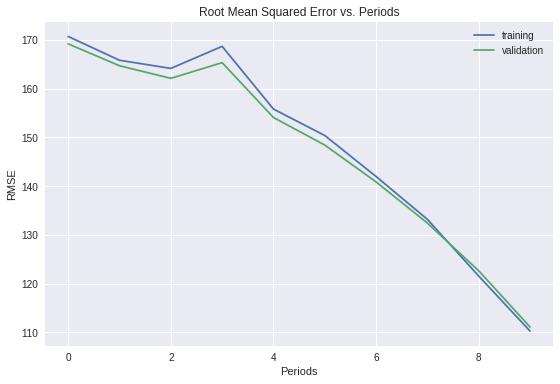

In [25]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

**Linear Scaling**
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.



In [0]:
def linear_scale(series):
  min_val=series.min()
  max_val=series.max()
  scale=(max_val-min_val)/2.0
  return series.apply(lambda x:((x-min_val)/scale)-1.0)

**Task 1: Normalize the Features Using Linear Scaling**
Normalize the inputs to the scale -1, 1.

Spend about 5 minutes training and evaluating on the newly normalized data. How well can you do?

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

Training model...
RMSE (on training data):
  period 00 : 158.99
  period 01 : 110.55
  period 02 : 97.75
  period 03 : 83.35
  period 04 : 77.01
  period 05 : 75.08
  period 06 : 73.87
  period 07 : 72.77
  period 08 : 71.58
  period 09 : 70.93
Model training finished.
Final RMSE (on training data):   70.93
Final RMSE (on validation data): 71.58


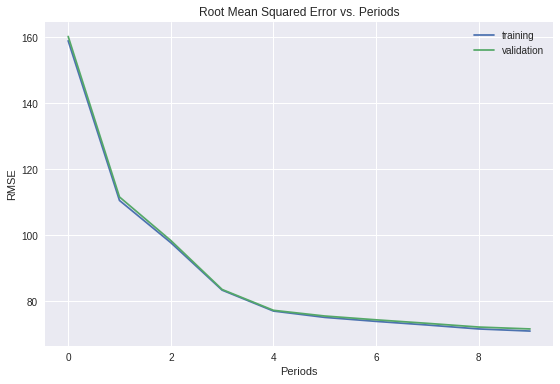

In [27]:
def normalize_linear_scale(examples_dataframe):
  
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Task 2: Try a Different Optimizer
Use the Adagrad and Adam optimizers and compare performance.

The Adagrad optimizer is one alternative. The key insight of Adagrad is that it modifies the learning rate adaptively for each coefficient in a model, monotonically lowering the effective learning rate. This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training. You can use Adagrad by specifying AdagradOptimizer instead of GradientDescentOptimizer. Note that you may need to use a larger learning rate with Adagrad.

For non-convex optimization problems, Adam is sometimes more efficient than Adagrad. To use Adam, invoke the tf.train.AdamOptimizer method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (learning_rate). In a production setting, you should specify and tune the optional hyperparameters carefully.

Training model...
RMSE (on training data):
  period 00 : 78.09
  period 01 : 73.29
  period 02 : 71.65
  period 03 : 70.27
  period 04 : 69.44
  period 05 : 74.17
  period 06 : 66.80
  period 07 : 68.12
  period 08 : 66.31
  period 09 : 66.88
Model training finished.
Final RMSE (on training data):   66.88
Final RMSE (on validation data): 67.64


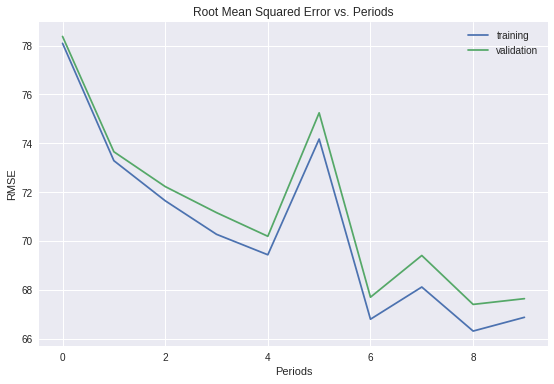

In [28]:
#Adagrad
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 204.21
  period 01 : 119.46
  period 02 : 113.97
  period 03 : 108.81
  period 04 : 101.97
  period 05 : 91.25
  period 06 : 79.92
  period 07 : 72.49
  period 08 : 70.43
  period 09 : 70.10
Model training finished.
Final RMSE (on training data):   70.10
Final RMSE (on validation data): 70.89


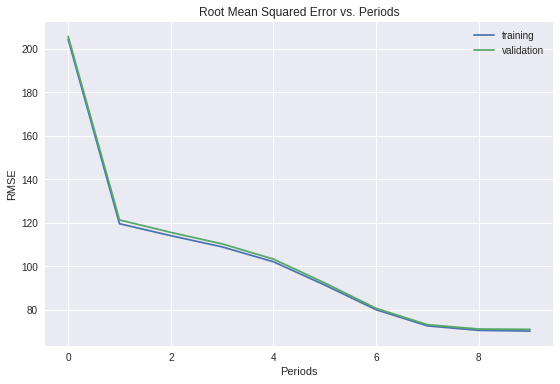

In [29]:
#Adam
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

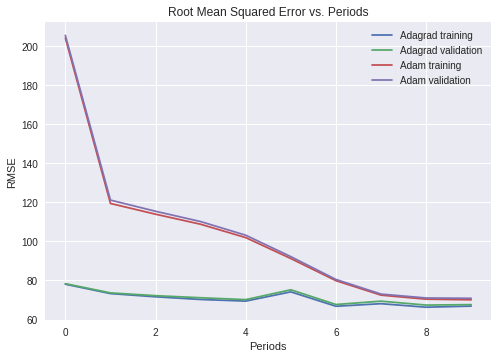

In [30]:
#Graph
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

**Task 3: Exploring Alternate Normalization Methods**
Trying alternate normalizations for various features to further improve performance.

If we look closely at summary stats for your transformed data, we willnotice that linear scaling some features leaves them clumped close to -1.

For example, many features have a median of -0.8 or so, rather than 0.0.



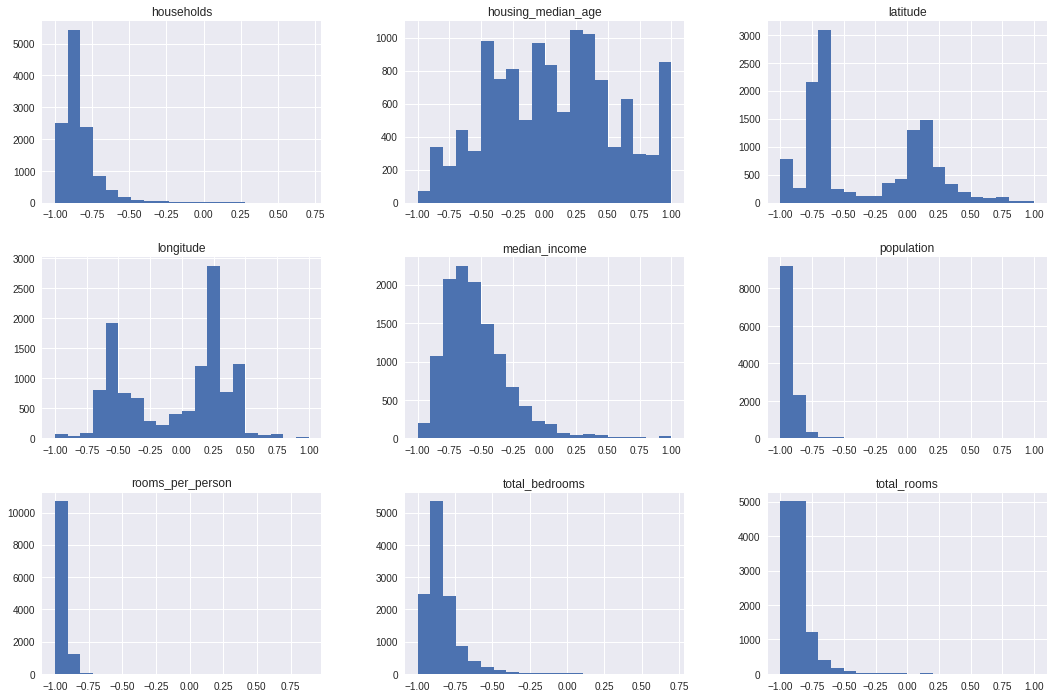

In [31]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [0]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

Training model...
RMSE (on training data):
  period 00 : 82.96
  period 01 : 75.22
  period 02 : 71.45
  period 03 : 70.47
  period 04 : 70.02
  period 05 : 69.29
  period 06 : 69.05
  period 07 : 68.43
  period 08 : 69.07
  period 09 : 67.75
Model training finished.
Final RMSE (on training data):   67.75
Final RMSE (on validation data): 67.38


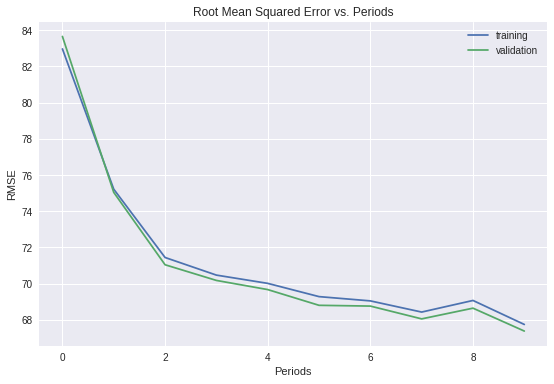

In [33]:
def normalize(examples_dataframe):
  
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

CHALLENGE:Using only Latitude and Longitude as features

Training model...
RMSE (on training data):
  period 00 : 177.82
  period 01 : 107.77
  period 02 : 103.74
  period 03 : 101.24
  period 04 : 100.33
  period 05 : 101.15
  period 06 : 99.17
  period 07 : 99.15
  period 08 : 98.57
  period 09 : 98.99
Model training finished.
Final RMSE (on training data):   98.99
Final RMSE (on validation data): 101.06


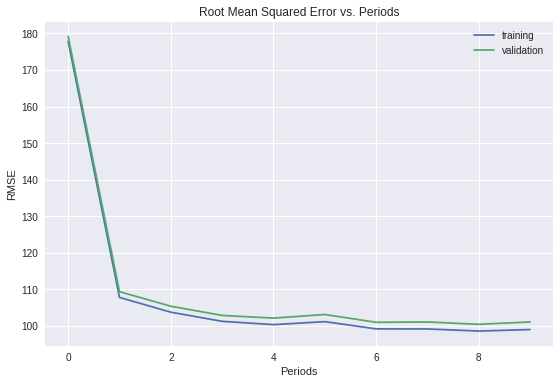

In [36]:
def location(examples_dataframe):
  processed_features=pd.DataFrame()
  processed_features['latitude']=linear_scale(examples_dataframe['latitude'])
  processed_features['longitude']=linear_scale(examples_dataframe['longitude'])
  return processed_features
loc_dataframe=location(preprocess_features(california_housing_dataframe))
loc_training_examples=loc_dataframe.head(12000)
loc_validation_examples=loc_dataframe.tail(5000)
_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=loc_training_examples,
    training_targets=training_targets,
    validation_examples=loc_validation_examples,
    validation_targets=validation_targets)